In [1]:
import warnings

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

warnings.filterwarnings('ignore')

In [2]:
health_data = pd.read_csv("../b. Datasets/Cardiac Risk/CardiacRisk.csv")

In [3]:
display(health_data.head(2))
display(health_data.tail(2))

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CVD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,CVD
4238,1,40,3.0,0,0.0,0.0,0,1,0,185.0,141.0,98.0,25.60,67.0,72.0,0
4239,0,39,3.0,1,30.0,0.0,0,0,0,196.0,133.0,86.0,20.91,85.0,80.0,0


In [4]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             4240 non-null   int64  
 1   age              4240 non-null   int64  
 2   education        4135 non-null   float64
 3   currentSmoker    4240 non-null   int64  
 4   cigsPerDay       4211 non-null   float64
 5   BPMeds           4187 non-null   float64
 6   prevalentStroke  4240 non-null   int64  
 7   prevalentHyp     4240 non-null   int64  
 8   diabetes         4240 non-null   int64  
 9   totChol          4190 non-null   float64
 10  sysBP            4240 non-null   float64
 11  diaBP            4240 non-null   float64
 12  BMI              4221 non-null   float64
 13  heartRate        4239 non-null   float64
 14  glucose          3852 non-null   float64
 15  CVD              4240 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 530.1 KB


In [5]:
health_data.describe().T

,count,mean,std,min,25%,50%,75%,max
male,4240.0,0.429245,0.495027,0.00,0.00,0.0,1.00,1.0
age,4240.0,49.580189,8.572942,32.00,42.00,49.0,56.00,70.0
education,4135.0,1.979444,1.019791,1.00,1.00,2.0,3.00,4.0
currentSmoker,4240.0,0.494104,0.500024,0.00,0.00,0.0,1.00,1.0
cigsPerDay,4211.0,9.005937,11.922462,0.00,0.00,0.0,20.00,70.0
BPMeds,4187.0,0.029615,0.169544,0.00,0.00,0.0,0.00,1.0
prevalentStroke,4240.0,0.005896,0.076569,0.00,0.00,0.0,0.00,1.0
prevalentHyp,4240.0,0.310613,0.462799,0.00,0.00,0.0,1.00,1.0
diabetes,4240.0,0.025708,0.158280,0.00,0.00,0.0,0.00,1.0
totChol,4190.0,236.699523,44.591284,107.00,206.00,234.0,263.00,696.0


In [6]:
health_data.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
CVD                  0
dtype: int64

In [7]:
health_data.skew()

male                0.285997
age                 0.228867
education           0.688730
currentSmoker       0.023595
cigsPerDay          1.247052
BPMeds              5.551462
prevalentStroke    12.912160
prevalentHyp        0.818827
diabetes            5.995907
totChol             0.871881
sysBP               1.145285
diaBP               0.713250
BMI                 0.982183
heartRate           0.644372
glucose             6.214948
CVD                 1.940516
dtype: float64

In [8]:
health_data.fillna(health_data.median(), inplace=True)
health_data.isna().sum().sum()

0

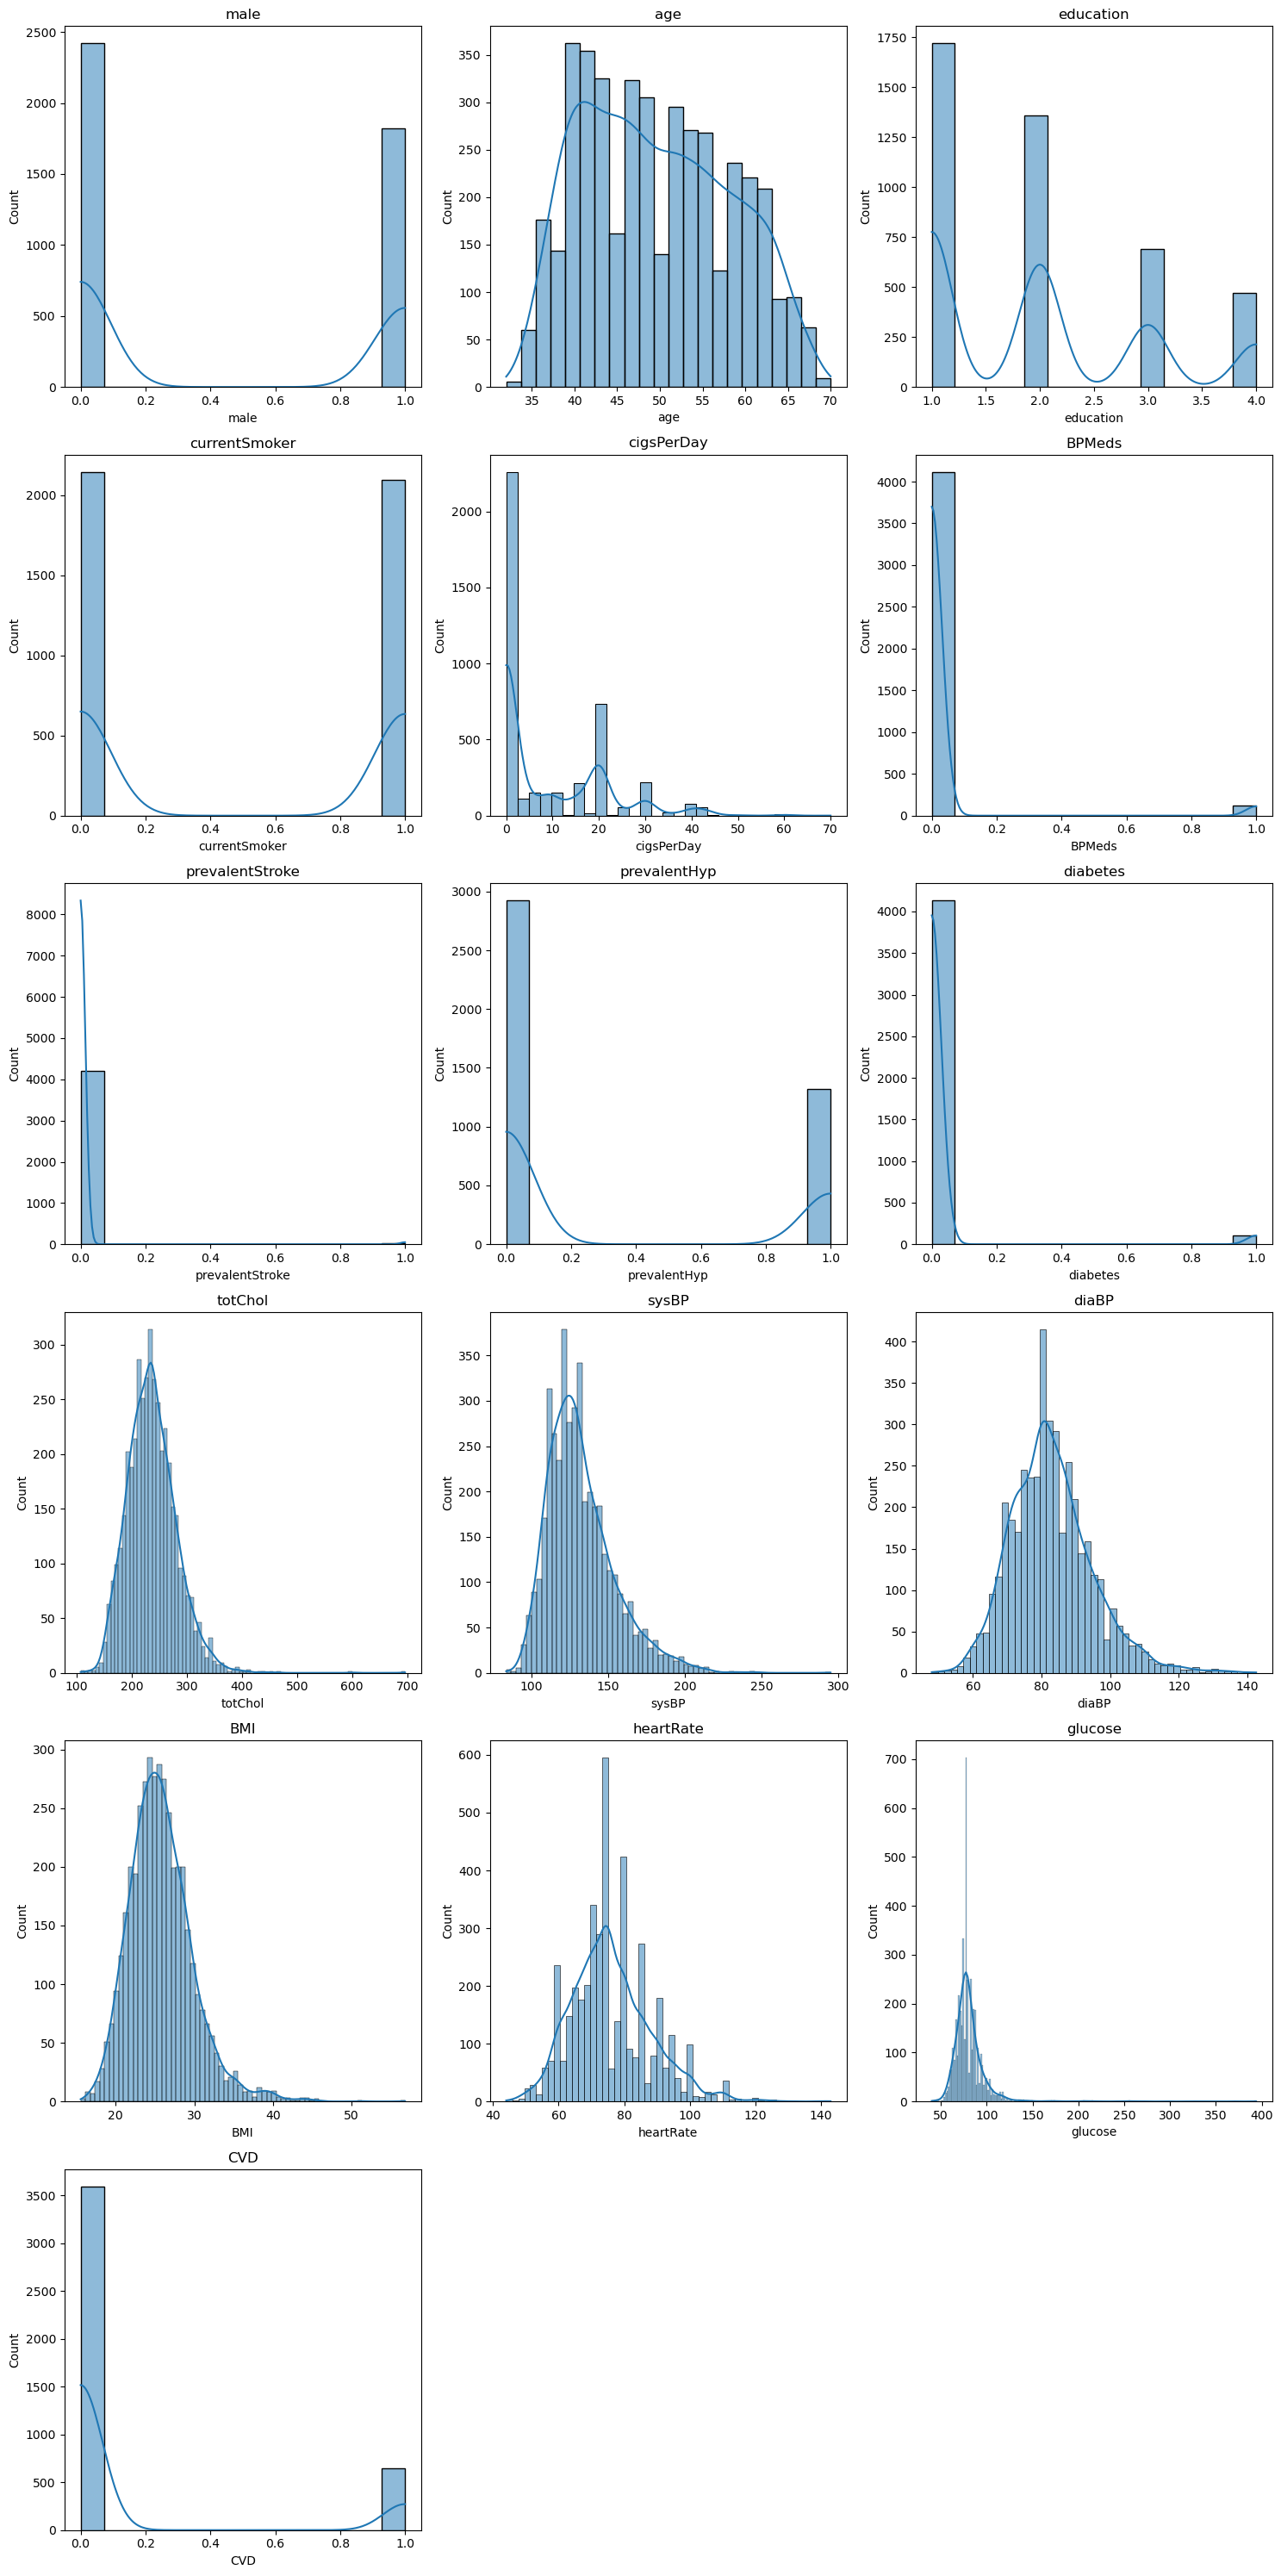

In [9]:
numerical_features = health_data.select_dtypes(include='number')
num_cols = 3
num_rows = (len(numerical_features.columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(numerical_features.columns):
    sns.histplot(data=health_data, x=col, ax=axes[idx], kde=True)
    axes[idx].set_title(col)

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [10]:
X = health_data.drop(labels='CVD', axis=1)
y = health_data['CVD']

display(X.head(2))
display(y.head(2))

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0


0    0
1    0
Name: CVD, dtype: int64

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

smote = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [12]:
display(X_train.head(2))
display(X_test.head(2))
display(y_train.head(2))
display(y_test.head(2))

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,43,4.0,1,20.0,0.0,0,0,0,187.0,129.5,88.0,25.62,80.0,75.0
1,1,43,1.0,1,20.0,0.0,0,0,0,180.0,131.0,92.0,27.18,65.0,85.0


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
1465,0,47,1.0,1,20.0,0.0,0,1,0,325.0,160.0,95.0,32.07,95.0,87.0
302,0,55,1.0,0,0.0,0.0,0,0,0,220.0,117.5,84.0,26.20,90.0,78.0


0    0
1    1
Name: CVD, dtype: int64

1465    0
302     0
Name: CVD, dtype: int64

In [13]:
extreme_gradient_boosting = XGBClassifier()

param_grid = {
    'max_depth': [3,4,5,6],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'n_estimators': [100, 200, 300, 500, 1000],
    'lambda': [1, 5, 10, 20],
    'alpha': [1, 5, 10, 20]
}

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

random_search_cv = RandomizedSearchCV(estimator=extreme_gradient_boosting, 
                                      cv=stratified_k_fold,
                                      param_distributions=param_grid, 
                                      n_iter=15, 
                                      scoring='f1',
                                      random_state=0)

random_search_cv.fit(X_train, y_train)

best_xgb = random_search_cv.best_estimator_
best_params = random_search_cv.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.1, 'lambda': 5, 'colsample_bytree': 1.0, 'alpha': 1}


In [14]:
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

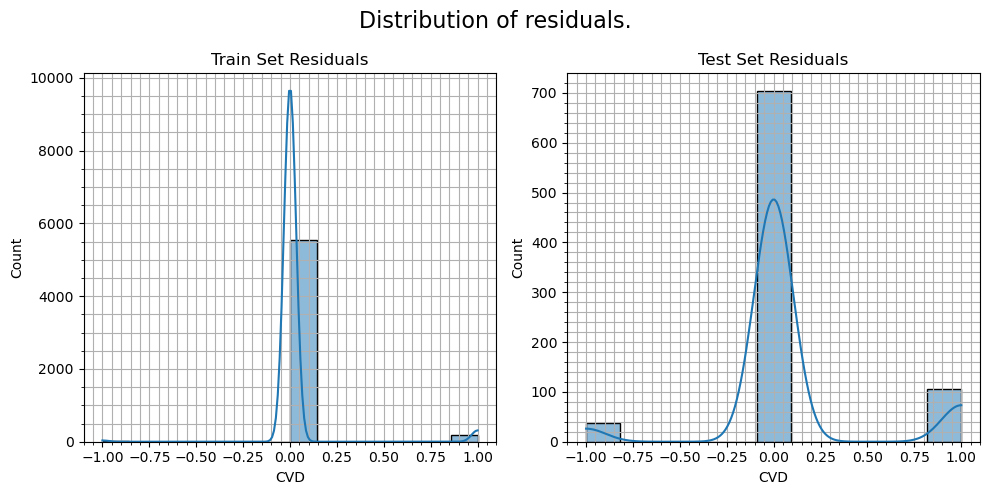

In [15]:
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=train_residuals, kde=True)
plt.minorticks_on()
plt.grid(which='both')
plt.title("Train Set Residuals")

plt.subplot(1, 2, 2)
sns.histplot(data=test_residuals, kde=True)
plt.minorticks_on()
plt.grid(which='both')
plt.title("Test Set Residuals")

plt.suptitle("Distribution of residuals.", fontsize=16)
plt.tight_layout()
plt.show()

In [16]:
y_test_prob = best_xgb.predict_proba(X_test)
cm = confusion_matrix(y_test, y_test_pred)

# Converting the confusion matrix to DataFrame.
cm_df = pd.DataFrame(cm, index=['True', 'False'], columns=['Positive', 'Negative'])

print("Confusion Matrix:")
display(cm_df)

Confusion Matrix:


,Positive,Negative
True,684,38
False,106,20


In [17]:
report = classification_report(y_test, y_test_pred, output_dict=True)
# Converting the classification report (which is a dictionary) to DataFrame and transposing for better readability.
report_df = pd.DataFrame(report).T

print("Classification Report:")
display(report_df)

Classification Report:


,precision,recall,f1-score,support
0,0.865823,0.947368,0.904762,722.000000
1,0.344828,0.158730,0.217391,126.000000
accuracy,0.830189,0.830189,0.830189,0.830189
macro avg,0.605325,0.553049,0.561077,848.000000
weighted avg,0.788411,0.830189,0.802629,848.000000


In [18]:
accuracy = accuracy_score(y_test, y_test_pred)
auc_value = roc_auc_score(y_test, y_test_prob[:, 1])
# Tablular format for accuracy and AUC.
metrics = {
    'Metric': ['Accuracy', 'ROC-AUC'],
    'Score': [accuracy, auc_value]
}
metrics_df = pd.DataFrame(metrics)

print("Other Metrics:")
display(metrics_df)

Other Metrics:


,Metric,Score
0,Accuracy,0.830189
1,ROC-AUC,0.672471


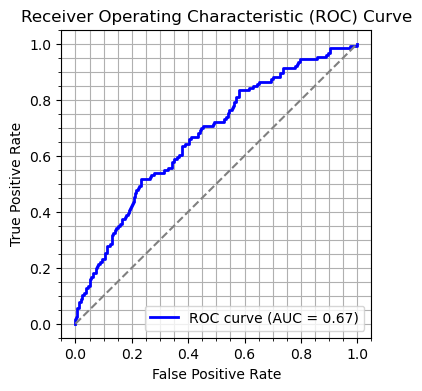

In [19]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='green', linestyle='--') # To indicate the random guessing probability.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.minorticks_on()
plt.grid(which='both')
plt.show()

In [20]:
submission_dataframe = pd.DataFrame({
    'index': X_test.index,
    'CVD': y_test_pred
})
submission_dataframe.head(2)

,index,CVD
0,1465,0
1,302,0


In [21]:
submission_dataframe_file = ('../d. Output Files/CardiacRisk/' + 'CardiacRisk_Prediction.csv')
print(f"File name: {submission_dataframe_file.split('/')[3]}")
submission_dataframe.sort_values(by='index', inplace=True)
submission_dataframe.to_csv(submission_dataframe_file, index=False)

File name: CardiacRisk_Prediction.csv
